In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
import random
import numpy as np
import tensorflow as tf

from skimage.io import imread
from skimage import transform

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

/home/florian/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/florian/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Transfar Learning and Data Augmentation

Two of the most important techniques when doing any kind of applied deep learning on image data are transfer learning and data augmentation. Typically, we will not have enough data to adequately train a deep neural network to it's full potential. By using a pretrained network and artificially increasing the size of our data with augmentations we can often acheive much higher performance than if we trained our network from scratch on a small dataset. 

With transfer learning we take a neural network that has been trained on some other dataset. Typically some large academic benchmark dataset with upwards of a million images. We then remove the layers that are specific to the original problem (typically just the classification layers at the end) and replace them with layers that will generate the desired output type for our problem. 

With data augmentation we artificially increase the size of our dataset by perturbing the images in random ways. We can flip images left-right, take random crops, shear the image, rotate it, and so on. For example, an image changed in these ways will still contain a cat but it will be like have many different variations of that same cat image. 

![Imgur](http://i.imgur.com/rW0a8Yx.png)![Imgur](http://i.imgur.com/Xg6zouG.gif)

## Dogs vs Cats

In this example we will create an image classifier that can distinguish pictures of cats vs dogs. We'll use a small dataset with 400 cat images and 400 dog images. First, we must load the images and labels into numpy arrays so they can be used.

In [2]:
# the original net that we will finetune was trained with 32x32 images
PATH = 'dogs_v_cats/'
PIXELS = 32

class_dict = {0: 'Cat', 
              1: 'Dog'}

def load_images(path):
    # read all of the image files in the directory
    names = [d for d in os.listdir(path) if d.endswith('.jpg')]
    
    print('Making dataset')
    # set up an empty numpy array for our images
    training_images = np.zeros((len(names), PIXELS, PIXELS, 3), dtype=np.float32)
    labels = np.zeros((len(names), 2), dtype=np.float32)
    for i, n in enumerate(names):
        #print n
        img = imread(os.path.join(path, n))
        # skimage loads image as (height, width, channel) for RGB images channels = 3
        img = transform.resize(img, output_shape=(PIXELS, PIXELS , 3), preserve_range=True)
        training_images[i,:,:,:] = img / 255.
        
        # check the label on the filename and encode the label into integers
        if n.split('.')[0] == 'cat':
            labels[i,0] = 1 # I'm sort of a dog person so dogs will be 1
        else:
            labels[i,1] = 1
            
    return training_images, labels

X_train, y_train = load_images(PATH)
print(X_train.shape)
print(y_train.shape)
print('Done!')

/home/florian/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Making dataset
(802, 32, 32, 3)
(802, 2)
Done!


### Display some of the images

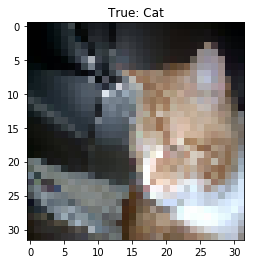

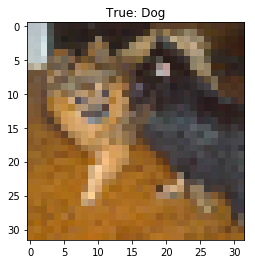

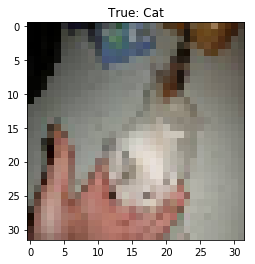

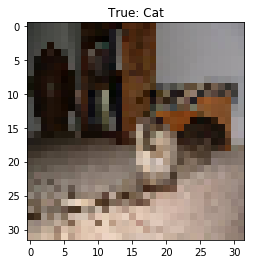

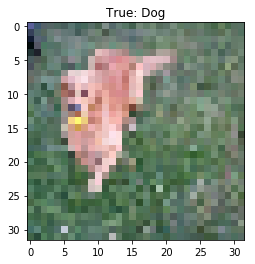

In [4]:
from random import randint
%matplotlib inline
import matplotlib.pyplot as plt

def plot_sample(img, label):
    plt.imshow(img)
    plt.title('True: {}'.format(class_dict[np.argmax(label)]))
    plt.show(block=True)

# We'll pick 5 random images, plot them and print their labels
for _ in range(0,5):
    j = randint(0, X_train.shape[0])
    plot_sample(X_train[j], y_train[j])

## Transfer Learning

We will use the checkpoint files created from another convolutional neural network that was trained on the [Cifar-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). It's a dataset of 60,000 images and 10 classes. 

![cifar-10](images/cifar-10.png)

The first step is to load up those checkpoint files. Then, we must get the tensors for the input and last dense layer before the classification layer. If we were not the ones that created and trained the network we may not know the names of those inputs and outputs so we will have to print the operation names. This is where good naming of your TF objects really comes in handy.

This saver object that we create will load the weights and graph from the pretrained model.  

In [ ]:
saver = tf.train.import_meta_graph('./cifar-10_saved_model/cifar10-cnn.ckpt.meta', 
                                   clear_devices=True)

with tf.name_scope('old_model'):
    # set tf to use the graph from this checkpoint
    graph = tf.get_default_graph()

    # get the input placeholder and output logits from the graph
    # we will use these to build our own training 
    img_input = graph.get_tensor_by_name('input_placeholder/X:0')
    dense_out = graph.get_tensor_by_name('cnn/dense_layer/dense_layer_out:0')

The `dense_out` layer will create a 128 dimensional vector for each image. This is the vector that will feed into our classification layer that we have yet to create.

At this point we have our input placeholder, taken directly from the restored graph. We have our cnn image representations. So all we need to do is create an output layer, a two class prediction, set up our loss, and training algorithm. 

In [ ]:
def output_layer(X, n_units, name):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_units)
        init = tf.truncated_normal((n_inputs, n_units), stddev=stddev)
        W = tf.Variable(init, name='hidden_weights_{}'.format(name))
        b = tf.Variable(tf.zeros([n_units]), name='bias_{}'.format(name))
        logits = tf.add(tf.matmul(X, W), b, name='logits_{}'.format(name))
        
    return logits

with tf.name_scope('targets_placeholder'):
    y = tf.placeholder(tf.float32, shape=(None, 2))

with tf.name_scope('new_output'):
    y_logits = output_layer(dense_out, 2, name='output')
    
with tf.name_scope('prediction'):
    prediction = tf.nn.softmax(y_logits)
    
with tf.name_scope('accuracy'):
    corrects = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, 
                                                                  logits=y_logits))
with tf.name_scope('training_algo'):
    train_step = tf.train.AdamOptimizer(0.0003, name='finetune_adam').minimize(loss)

## Retraining the network with data augmentation

Now that we've created our new graphs by reusing some layers from a pretrained network it's time to fine-tune that network for our new dataset. We will do this will the dogs and cats images, and horizontally flip half of the images coming into our mini-batch. We'll do this by using `numpy`'s built in `fliplr`. Make sure to restore the weights for the old network by using `saver.restore` otherwise we'll just use that network as if we were training from scratch. The weights only exist in a session, think of the restore function as a type of initialization. After running this once try commenting out `saver.restore` and see how that impacts the performance. Transfer learning should give you the best accuracy.

In [ ]:
EPOCHS = 75
BATCHSIZE = 16

init = tf.global_variables_initializer()

# split data into training and testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
n_samples = len(X_train)

with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, './cifar-10_saved_model/cifar10-cnn.ckpt')

    step = 0
    for e in range(EPOCHS):
        accs = []
        losses = []
        # shuffle the training data
        X_train, y_train = shuffle(X_train, y_train)
        for i in range((n_samples + BATCHSIZE - 1) // BATCHSIZE):
            sl = slice(i * BATCHSIZE, (i+1) * BATCHSIZE)
            X_b = X_train[sl]
            y_b = y_train[sl]

            # random flip some images
            flip_idxs = random.sample(range(len(X_b)), int(len(X_b) * 0.5))
            for i in flip_idxs:
                X_b[i] = np.fliplr(X_b[i])

            _, train_loss, train_acc = sess.run([train_step, loss, accuracy], 
                                                feed_dict={img_input: X_b, 
                                                y: y_b})
            losses.append(train_loss)
            accs.append(train_acc)

        if e % 5 == 0:
            valid_loss, valid_acc = sess.run([loss, accuracy], 
                                             feed_dict={img_input: X_val, 
                                             y: y_val})
            print("Epoch:", e)
            print("Train loss:", np.mean(losses),
                  "Train acc:", np.mean(accs))
            print("Valid loss:", valid_loss,
                  "Valid_acc:", valid_acc)
            print()
            
    # after training, make predictions on val to visualize
    preds = sess.run(prediction, feed_dict={img_input: X_val})
    pred_val = tf.argmax(preds, 1).eval()

In [ ]:
for j in range(10):
    plt.imshow(X_val[j].squeeze())
    plt.title('True: {} | Predicted: {}'.format(class_dict[np.argmax(y_val[j])],
                                                class_dict[pred_val[j]]))
    plt.show()